<a href="https://colab.research.google.com/github/Sonlowami/HAI-DEF-Learn/blob/main/classify_images_with_natural_language_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

In [ ]:
from huggingface_hub import HfFolder
if HfFolder.get_token() is None:
  from huggingface_hub import notebook_login
  notebook_login()
else:
  print('token is already set')

token is already set


In [ ]:
import pandas as pd
import numpy as np
from huggingface_hub import hf_hub_download
REPO_ID = 'google/cxr-foundation'
EMBEDDING_NPZ_PATH = hf_hub_download(REPO_ID,
                                     filename='embeddings.npz',
                                     subfolder='precomputed_embeddings')
embeddings = np.load(EMBEDDING_NPZ_PATH)
embeddings.get('00000001_001').shape

(4096,)

In [ ]:
image_embeddings_df = pd.DataFrame(
    [(k,embeddings[k]) for k in embeddings.keys()],
    columns=['image_id', 'embedding']
)
embeddings.close()
image_embeddings_df.head()

,image_id,embedding
0,00015845_007,"[-0.17128147, 0.008595931, -0.0005963545, 0.06..."
1,00008774_005,"[-0.19136983, -0.06103782, -0.027953472, 0.070..."
2,00022600_001,"[-0.14782454, -0.030647462, -0.13165669, 0.003..."
3,00017324_012,"[-0.104966134, 0.021651793, -0.14169557, -0.00..."
4,00021311_000,"[-0.113549404, 0.03401351, -0.2252285, 0.20830..."


In [ ]:
TEXT_EMBEDDINGS_PATH = hf_hub_download(REPO_ID,
                                       filename='text_embeddings.npz',
                                       subfolder='precomputed_embeddings')
text_embeddings = np.load(TEXT_EMBEDDINGS_PATH)
print(text_embeddings['Enlarged Cardiomediastinum'].shape)
embeddings_df = pd.DataFrame(
    [(k, v) for k, v in text_embeddings.items()],
    columns=['query', 'embedding']
)
text_embeddings_queries = list(text_embeddings.keys())
text_embeddings.close()
embeddings_df.head()

(128,)


,query,embedding
0,Enlarged Cardiomediastinum,"[-0.06839325, 0.016583007, -0.043305214, 0.006..."
1,enlarged cardiomediastinum,"[-0.06839325, 0.016583007, -0.043305214, 0.006..."
2,widened cardiomediastinum,"[-0.18843561, -0.03300752, -0.11934988, -0.053..."
3,no acute cardiopulmonary process,"[-0.05057713, -0.061462577, -0.039064746, -0.1..."
4,cardiomediastinal silhouette is normal,"[0.13671014, -0.014474957, 0.12604094, -0.1434..."


In [ ]:
LABEL_FILE_PATH = hf_hub_download(repo_id=REPO_ID,
                                  filename='labels.csv',
                                  subfolder='precomputed_embeddings')
labels_df = pd.read_csv(LABEL_FILE_PATH)
labels_df.head()

precomputed_embeddings/labels.csv:   0%|          | 0.00/197k [00:00<?, ?B/s]

,image_id,patient_id,case_id,split,AIRSPACE_OPACITY,FRACTURE,PNEUMOTHORAX,CONSOLIDATION,EFFUSION,PULMONARY_EDEMA,ATELECTASIS,CARDIOMEGALY,dicom_file
0,00015845_007,15845,7,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00015845_007.dcm
1,00008774_005,8774,5,train,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,00008774_005.dcm
2,00022600_001,22600,1,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00022600_001.dcm
3,00017324_012,17324,12,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00017324_012.dcm
4,00021311_000,21311,0,train,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,00021311_000.dcm


In [ ]:
def softmax(x):
  exp_x = np.exp(x - np.max(x))
  return exp_x / exp_x.sum(axis=0)

def calculate_similarity(image_emb, text_embed):
  image_emb = np.reshape(image_emb, (32, 128))
  similarities = []
  for emb in image_emb:
    similarity  = np.dot(emb, text_embed) / (np.linalg.norm(emb) * np.linalg.norm(text_embed))
    similarities.append(similarity)
  sim_np = np.array(similarities)
  return np.max(sim_np)

def zero_shot(image_emb, pos_text, neg_text):
  pos_cosine = calculate_similarity(image_emb, pos_text)
  neg_cosine = calculate_similarity(image_emb, neg_text)

  return pos_cosine - neg_cosine

In [ ]:
def get_text_embeddings_for_diagnosis(diagnosis):
  """
  This function takes a diagnosis as input and outputs the positive and negative text queries.
  """
  column_to_pos_neg = {
      'AIRSPACE_OPACITY': ('Airspace Opacity', 'no evidence of airspace disease'),
      'PNEUMOTHORAX': ('small pneumothorax', 'no pneumothorax'),
      'EFFUSION': ('large pleural effusion', 'no pleural effusion'),
      'PULMONARY_EDEMA': ('moderate pulmonary edema', 'no pulmonary edema'),
  }

  pos_txt, neg_txt = column_to_pos_neg[diagnosis]


  return pos_txt, neg_txt

In [ ]:
def compute_similarities(eval_df, pos_text, neg_text):
  pos_emb = embeddings_df.set_index('query').loc[pos_text, 'embedding']
  neg_emb = embeddings_df.set_index('query').loc[neg_text, 'embedding']

  for index, row in eval_df.iterrows():
    image_id = row['image_id']
    img_emb = image_embeddings_df.set_index('image_id').loc[image_id, 'embedding']
    similarity = zero_shot(img_emb, pos_emb, neg_emb)
    eval_df.loc[index, 'score'] = similarity

Dropdown(description='Diagnosis:', index=3, options=('AIRSPACE_OPACITY', 'PNEUMOTHORAX', 'EFFUSION', 'PULMONAR…

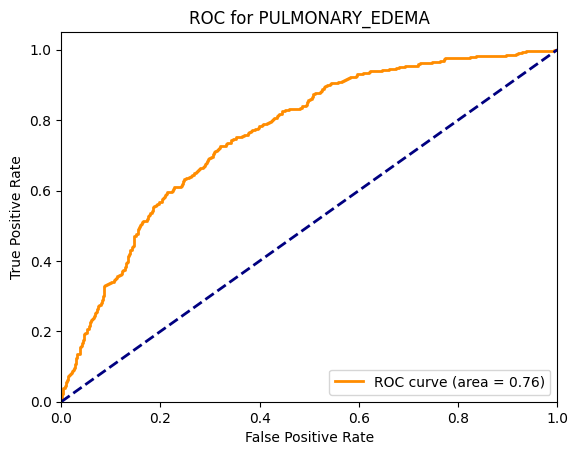

In [ ]:
# @title Evaluate and graph AUC

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

diagnosis_columns = ['AIRSPACE_OPACITY', 'PNEUMOTHORAX', 'EFFUSION', 'PULMONARY_EDEMA']

diagnosis_dropdown = widgets.Dropdown(
    options=diagnosis_columns,
    description='Diagnosis:',
    disabled=False,
)

text_input_pos = widgets.Combobox(
    placeholder='Type positive text...',
    options=text_embeddings_queries,
    ensure_option=True  # Ensures that the typed value is in the options
)

text_input_neg = widgets.Combobox(
    placeholder='Type negative text...',
    options=text_embeddings_queries,
    ensure_option=True  # Ensures that the typed value is in the options
)

clear_button_pos = widgets.Button(description="Change Positive Text")
clear_button_neg = widgets.Button(description="Change Negative Text")
clear_button_pos.on_click(lambda b: text_input_pos.set_trait('value', ''))
clear_button_neg.on_click(lambda b: text_input_neg.set_trait('value', ''))

processing = False

def draw_auc_plot(column, pos_txt = None, neg_txt = None):
  if pos_txt == '' or neg_txt == '':
    return
  global processing
  if processing:
    return
  processing = True
  clear_output(True)
  print('Computing, please wait')
  if pos_txt is None:
    pos_txt, neg_txt = get_text_embeddings_for_diagnosis(column)
    text_input_pos.value = pos_txt
    text_input_neg.value = neg_txt

  eval_data_df = labels_df[labels_df[column].isin([0, 1])][['image_id', column]].copy()
  eval_data_df.rename(columns={column: 'label'}, inplace=True)

  compute_similarities(eval_data_df, pos_txt, neg_txt)

  clear_output()
  display(diagnosis_dropdown)

  # Assuming 'eval_data_df' is your DataFrame with 'label' and 'score' columns
  fpr, tpr, thresholds = roc_curve(eval_data_df['label'], eval_data_df['score'])
  roc_auc = auc(fpr, tpr)

  plt.figure()
  lw = 2
  plt.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc,
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"ROC for {column}")
  plt.legend(loc="lower right")
  plt.show()
  # Create a horizontal box to display image and score
  display(widgets.HBox([
          widgets.Label(value="Using positive text query"),
          text_input_pos,
          clear_button_pos
        ]))
  display(widgets.HBox([
        widgets.Label(value="Negative text query "),
        text_input_neg,
        clear_button_neg
      ]))
  processing = False

def update_plot(change):
  draw_auc_plot(change.new)

def on_text_change(change):
  if change.new:
    draw_auc_plot(diagnosis_dropdown.value, text_input_pos.value, text_input_neg.value)



diagnosis_dropdown.observe(update_plot, names='value')
display(diagnosis_dropdown)
draw_auc_plot(diagnosis_dropdown.value)

text_input_pos.observe(on_text_change, names='value')
text_input_neg.observe(on_text_change, names='value')